In [1]:
import numpy as np 
import os 
import pandas as pd 
# from scipy import sparse
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.python_utils import get_top_k_scored_items
from recommenders.utils.timer import Timer
from sklearn.preprocessing import minmax_scale
from recommenders.utils.python_utils import binarize
from recommenders.evaluation.python_evaluation import (map_at_k, ndcg_at_k)

In [2]:
def load_df(size="1"):
  if(size==5):
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_1.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
    for i in range(2,5):
      df_temp = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{i}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
      df.append(df_temp)
  else:
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{size}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
  df.index = np.arange(0,len(df))
  df_nan = pd.DataFrame(pd.isnull(df.rating))
  df_nan = df_nan[df_nan['rating'] == True]
  df_nan = df_nan.reset_index()
  movie_np = []
  movie_id = 1
  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)
  df = df[pd.notnull(df['rating'])]
  df['itemID'] = movie_np.astype(int)
  df['userID'] = df['userID'].astype(int)
  df['rating'] = df['rating'].astype(int)
  df = df[df["itemID"]<=1500]
  df = df[df["userID"]<=50000]
  return df

In [3]:
df = load_df()
index2item = dict(enumerate(df['itemID'].unique()))
index2user = dict(enumerate(df['userID'].unique()))
item2index = {v: k for k, v in index2item.items()}
user2index = {v: k for k, v in index2user.items()}
df['itemID'] = df.itemID.apply(lambda i : item2index[i])
df['userID'] = df.userID.apply(lambda u : user2index[u])
del index2item
del index2user
del user2index
del item2index

In [4]:
train, test = python_stratified_split(df, ratio=0.75, col_user='userID', col_item='itemID', seed=42)
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [5]:
X = train.pivot_table(index=["itemID"], columns=["userID"], values="rating").fillna(0)
X = X.to_numpy()
X = X.astype(int)

Combine all txt file to a output.csv as well adding movie_id

In [8]:
# import os
# import re
# dirPath = "./drive/MyDrive/netflix dataset/"
# docList =[]
# for filename in os.listdir(dirPath):
#     if (re.search("^combined_data.*.txt$", filename) is not None):
#         docList.append(dirPath+filename)
# dic = []
# with open("./drive/MyDrive/netflix dataset/output.csv", 'w+') as output:
#     output.write("movie_id,user_id,rating,date\n")
#     for fileName in docList:
#        with open(fileName, 'r') as file:
#         for _, line in enumerate(file):
#             if ':' in line:
#                 movie_id= line.replace(':', '').replace('\n', '')
# #             else:
#                 output.write(movie_id+","+line)
#         file.close()
#         del file
#     output.close()

In [9]:
# full_dataset = pd.read_csv('./drive/MyDrive/netflix dataset/output.csv',usecols = [0,1,2])

In [4]:
# def set_cont_id(column):
#     keys = column.unique()
#     key_to_id = {key:idx for idx,key in enumerate(keys)}
#     return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)
# def transform_df(df):
#     movie_ids, df['movie_id'], num_movies = set_cont_id(df['movie_id'])
#     user_ids, df['user_id'], num_users = set_cont_id(df['user_id'])
#     return num_users, num_movies, user_ids, movie_ids

In [11]:
# small_dataset = full_dataset[full_dataset["movie_id"]<=100]

In [12]:
# small_dataset.to_csv("./drive/MyDrive/netflix dataset/small_dataset.csv")

In [9]:
# del(full_dataset)

In [5]:
# small_dataset = pd.read_csv("./drive/MyDrive/netflix dataset/small_dataset.csv",usecols=[1,2,3])

In [6]:
num_users = len(train["userID"].unique())
num_movies = len(train["itemID"].unique())
print("Num of Users : ",num_users," Num of Movies : ",num_movies)

Num of Users :  8169  Num of Movies :  1410


In [7]:
# Algorith 1 Naive Bayes

# Defining Function use

#   #1 For creating sparse matrix
def create_sparse_matrix(df, rows, cols, column_name="rating"):
    return sparse.csc_matrix((df[column_name].values,(df['movie_id'].values, df['user_id'].values)),shape=(rows, cols))

#   #2 Naive bayes algo [“A Collaborative Filtering Approach Based on Naïve Bayes Classifier,”]

def naiveBayes(mat,a,rating_class):
#     initializing counters
    rating_class_length = rating_class.shape[0]
    num_movies = mat.shape[0]
    num_users = mat.shape[1]
    user_count = np.full((num_users),rating_class_length*a)
    item_count = np.full((num_movies),rating_class_length*a)
    prior_user_probab = np.full((num_users,rating_class_length),a)
    prior_item_probab = np.full((num_movies,rating_class_length),a)
    cond_item_probab = np.full((num_movies,rating_class_length,num_movies,rating_class_length),a)
    cond_user_probab = np.full((num_users,rating_class_length,num_users,rating_class_length),a)
    item_itemJ_count = np.full((num_movies,num_movies,rating_class_length),rating_class_length*a)
    user_userJ_count = np.full((num_users,num_users,rating_class_length),rating_class_length*a)
    for user in range(num_users):
        for item in range(num_movies):
            y=mat.item((item,user))
            if(y==0):
                continue
            prior_user_probab[user][y-1] = ((user_count[user]*prior_user_probab[user][y-1])+1)/(user_count[user]+1)
            user_count[user]+=1
            prior_item_probab[item][y-1] = ((item_count[item]*prior_item_probab[item][y-1])+1)/(item_count[item]+1)
            item_count+=1
            for item_j in range(num_movies):
                k = mat.item((item_j,user))
                if(k==0 or item_j==item):
                    continue
                cond_item_probab[item_j][k-1][item][y-1] = (item_itemJ_count[item_j][item][y-1]*cond_item_probab[item_j][k-1][item][y-1]+1)/(item_itemJ_count[item_j][item][y-1]+1)
                item_itemJ_count[item_j][item][y-1]+=1
            for user_j in range(num_users):
                k = mat.item((item,user_j))
                if(k==0 or user_j==user):
                    continue
                cond_user_probab[user_j][k-1][user][y-1] = (user_userJ_count[user_j][user][y-1]*cond_user_probab[user_j][k-1][user][y-1]+1)/(user_userJ_count[user_j][user][y-1]+1)
                user_userJ_count[user_j][user][y-1]+=1
    return (prior_user_probab,cond_user_probab,prior_item_probab,cond_item_probab)
def predict(mat,a,rating_class,prior_user_probab,cond_user_probab,prior_item_probab,cond_item_probab):    
    num_movies = mat.shape[0]
    num_users = mat.shape[1]
    prediction = np.full((num_movies,num_users),0)
    for i in range(num_users):
        for j in range(num_movies):
            rating=[]
            for k in range(rating_class.shape[0]):
                pip = prior_item_probab[j][k]
                likelihood_product = 1
                for l in range(num_movies):
                    ril = mat.item((l,i))
                    if(ril==0 or l==j):
                        continue
                    likelihood_product*=cond_item_probab[l][ril-1][j][k]
                rating.append(pip*likelihood_product)
            rating=np.array(rating)
            prediction[j][i] = rating.argmax()+1
    return prediction

#   #3 Finding Performance Metric

def confusion_matrix(original,prediction):
    conf_mat = np.full((5,5),0)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            if(original.item((i,j))==0):
                continue
            conf_mat[original.item((i,j))-1][prediction.item((i,j))-1]+=1
    return conf_mat
def MAE(original,prediction):
    numerator=0
    denominator=0
    for i in range(original.shape[0]):
        rating= 0
        count = 0
        for j in range(original.shape[1]):
            if(original.item((i,j))==0):
                continue
            rating+=(abs(original.item((i,j))-prediction.item((i,j))))
            count+=1
        numerator+=(rating/count)
        denominator+=1
    return numerator/denominator
def precision(original,prediction,threshold):
    numerator=0
    denominator=0
    for i in range(original.shape[0]):
        rating= 0
        count = 0
        for j in range(original.shape[1]):
            if(original.item((i,j))!=0):
                continue
            if(prediction.item((i,j))>=threshold):
                rating+=1
            count+=1
        numerator+=(rating/count)
        denominator+=1
    return numerator/denominator
def recall(original,prediction,threshold):
    numerator=0
    denominator=0
    for i in range(original.shape[0]):
        rating= 0
        count = 0
        for j in range(original.shape[1]):
            if(original.item((i,j))!=0):
                if(original.item((i,j))>=threshold):
                    count+=1
                continue
            if(prediction.item((i,j))>=threshold):
                rating+=1
        numerator+=(rating/count)
        denominator+=1
    return numerator/denominator
def performance_analysis(original,prediction,threshold):
    conf_mat = confusion_matrix(original,prediction)
    MAE = MAE(original,prediction)
    precision = precision(original,prediction,threshold)
    recall = recall(original,prediction,threshold)
    return (conf_mat,MAE,precision,recall)


In [8]:
sparcity = 100 - (np.count_nonzero(X)/(num_movies*num_users))*100
print("Spaprsity of data : ",sparcity)

Spaprsity of data :  99.07730227316729


In [9]:
rating_class = np.array([1,2,3,4,5])

In [10]:
prior_user_probab,cond_user_probab,prior_item_probab,cond_item_probab = naiveBayes(X,0.01,rating_class)
prediction = predict(X,0.01,rating_class,prior_user_probab,cond_user_probab,prior_item_probab,cond_item_probab)

In [12]:
prediction = np.transpose(prediction)

In [13]:
prediction.shape

(8169, 1410)

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(7,7)})

In [14]:
def score(prediction,test):
    user_ids = list(test['userID'].unique())
    test_scores = prediction[user_ids]
    return test_scores
def recommend_k_items(prediction, test, top_k=10, sort_top_k=True):
    test_scores = score(prediction,test)

    top_items, top_scores = get_top_k_scored_items(
        scores=test_scores, top_k=top_k, sort_top_k=sort_top_k
    )
    df = pd.DataFrame(
        {
            'userID': np.repeat(
                test['userID'].drop_duplicates().values, top_items.shape[1]
            ),
            'itemID': [item for item in top_items.flatten()],
            'prediction': top_scores.flatten(),
        }
    )

    # drop invalid items
    return df.replace(-np.inf, np.nan).dropna()

In [16]:
with Timer() as test_time:
    top_k = recommend_k_items(prediction,test, top_k=10)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 0.3152027999994971 seconds for prediction.


In [18]:
TOP_K=10
eval_map = map_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_ndcg = ndcg_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
print("Model:\t",
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      sep='\n')

Model:	
Top K:	10
MAP:	0.002144
NDCG:	0.006279


In [19]:
# conf_mat,MAE,precision,recall = performance_analysis(mat,prediction,3)
# print("MAE : ",MAE(mat,prediction))
# print("Precision : ",precision(mat,prediction,3))
# print("Recall : ",recall(mat,prediction,3))
# print("Confusion Matrix")
conf_mat = confusion_matrix(X,np.transpose(prediction))
print(conf_mat)

[[ 3662    69   347   346   126]
 [   32  7943  1019  1112   308]
 [   30   256 25021  3949   983]
 [   32   254  2683 32085  1770]
 [   46   101  1185  3849 19071]]


In [21]:
pip install seaborn

     ------------------------------------ 293.3/293.3 kB 566.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot: >

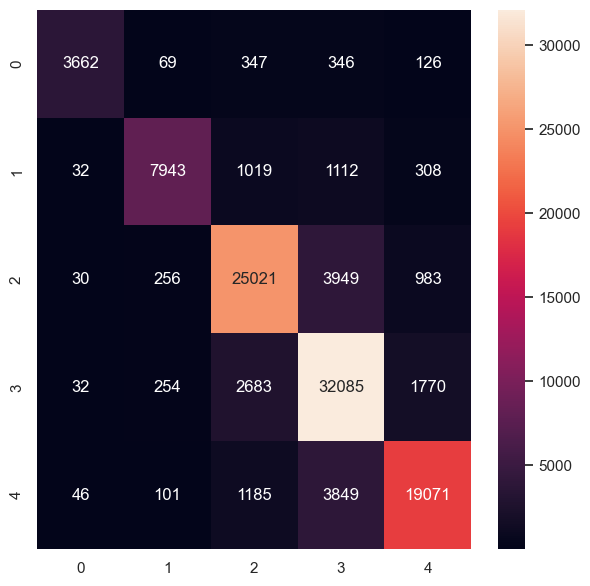

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(conf_mat,fmt='',annot=True)

In [7]:
len(test['rating'])

34860